In [1]:
import torch
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl
import sys 
import pandas as pd
import os
import optuna
import matplotlib.pylab as plt
%matplotlib inline
from lifelines.utils import concordance_index
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
from torchcontrib.optim import SWA
from pytorch_lightning import Trainer, seed_everything
from argparse import ArgumentParser
sys.path.append('../../data/')
sys.path.append('../../data/ml_mmrf')
sys.path.append('../../data/synthetic')
sys.path.append('../../data/semi_synthetic')
sys.path.append('../')
# from ml_mmrf.ml_mmrf_v1.data import load_mmrf
from ml_mmrf.data import load_mmrf
from synthetic_data import load_synthetic_data_trt, load_synthetic_data_noisy
from ss_data import *
from models.ssm.ssm import SSM, SSMAtt
from models.ssm.ssm_baseline import SSMBaseline
from models.rnn import GRU
from models.utils import *
print(torch.__version__)

1.6.0


In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

## alternate font/graph format
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rc('font', weight='heavy')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes', labelsize='x-large')

/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## NELBO, Pairwise Comparisons, Counts

In [3]:
mname = {}; models = {}; fold = 1
mmdata = load_mmrf(fold_span = [fold], \
                              digitize_K = 20, \
                              digitize_method = 'uniform', \
                              suffix='_2mos', \
                              restrict_markers=[], \
                              add_syn_marker=False, \
                              window='all', \
                              data_aug=False)
mname[f'ssm-cyc-att-fold{fold}'] = './checkpoints/ablation/mmfold_148_attn_transition_nonecyc_ssm_baseablationepoch=14835-val_loss=55.26.ckpt'
mname[f'ssm-car-att-fold{fold}'] = './checkpoints/ablation/mmfold_148_attn_transition_nonecar_ssm_baseablationepoch=14441-val_loss=57.88.ckpt'
mname[f'ssm-dex-att-fold{fold}'] = './checkpoints/ablation/mmfold_148_attn_transition_nonedex_ssm_baseablationepoch=14793-val_loss=57.53.ckpt'
mname[f'ssm-len-att-fold{fold}'] = './checkpoints/ablation/mmfold_148_attn_transition_nonelen_ssm_baseablationepoch=14890-val_loss=57.52.ckpt'
mname[f'ssm-lines-att-fold{fold}'] = './checkpoints/ablation/mmfold_164_attn_transition_nonelines_ssm_baseablationepoch=14962-val_loss=58.59.ckpt'
# mname[f'ssm-demog-att-fold{fold}'] = './checkpoints/ablation/mmfold_148_attn_transition_demoglines_ssm_baseablationepoch=14626-val_loss=58.22.ckpt'
# mname[f'ssm-iss-att-fold{fold}'] = './checkpoints/ablation/mmfold_164_attn_transition_isslines_ssm_baseablationepoch=14792-val_loss=58.04.ckpt'
# mname[f'ssm-pc-att-fold{fold}'] = './checkpoints/ablation/mmfold_164_attn_transition_pclines_ssm_baseablationepoch=12132-val_loss=58.63.ckpt'
# mname[f'ssm-hc-att-fold{fold}'] = './checkpoints/ablation/mmfold_164_attn_transition_hclines_ssm_baseablationepoch=13514-val_loss=59.42.ckpt'
# mname[f'ssm-igg-att-fold{fold}'] = './checkpoints/ablation/mmfold_148_attn_transition_igglines_ssm_baseablationepoch=14845-val_loss=60.36.ckpt'
mname[f'ssm-all-att-fold{fold}']  = './checkpoints/baseline_ablation/mmfold148_attn_transition_all_ssm_baseablationepoch=14435-val_loss=59.80.ckpt'
# mname[f'ssm-pc-att-fold{fold}'] = './checkpoints/ablation/mmfold_reducedfeats164_attn_transition_pclines_ssm_baseablationepoch=14874-val_loss=59.13.ckpt'
# mname[f'ssm-hc-att-fold{fold}'] = './checkpoints/ablation/mmfold_reducedfeats164_attn_transition_hclines_ssm_baseablationepoch=14923-val_loss=58.12.ckpt'
# mname[f'ssm-igg-att-fold{fold}'] = './checkpoints/ablation/mmfold_reducedfeats148_attn_transition_igglines_ssm_baseablationepoch=14773-val_loss=60.62.ckpt'
# mname[f'ssm-all-att-fold{fold}']  = './checkpoints/ablation/mmfold_reducedfeats148_attn_transition_alllines_ssm_baseablationepoch=14149-val_loss=60.04.ckpt'
# mname[f'ssm-none-att-fold{fold}'] = './checkpoints/ablation/mmfold_148_attn_transition_nonenone_trt_ssm_baseablationepoch=14664-val_loss=61.25.ckpt'

# mname[f'ssm-cyc-att-fold{fold}'] = './checkpoints/new_ablation/mmfold_Z1noise148_attn_transition_nonecyc_ssm_baseablationepoch=14923-val_loss=58.61.ckpt'
# mname[f'ssm-car-att-fold{fold}'] = './checkpoints/new_ablation/mmfold_Z1noise148_attn_transition_nonecar_ssm_baseablationepoch=14702-val_loss=64.97.ckpt'
# mname[f'ssm-dex-att-fold{fold}'] = './checkpoints/new_ablation/mmfold_Z1noise148_attn_transition_nonedex_ssm_baseablationepoch=14694-val_loss=60.20.ckpt'
# mname[f'ssm-len-att-fold{fold}'] = './checkpoints/new_ablation/mmfold_Z1noise148_attn_transition_nonelen_ssm_baseablationepoch=14781-val_loss=62.27.ckpt'
# mname[f'ssm-lines-att-fold{fold}'] = './checkpoints/new_ablation/mmfold_Z1noise164_attn_transition_nonelines_ssm_baseablationepoch=14951-val_loss=63.76.ckpt'
# mname[f'ssm-demog-att-fold{fold}'] = './checkpoints/new_ablation/mmfold_Z1noise164_attn_transition_demoglines_ssm_baseablationepoch=14986-val_loss=61.43.ckpt'
# mname[f'ssm-iss-att-fold{fold}'] = './checkpoints/new_ablation/mmfold_Z1noise164_attn_transition_isslines_ssm_baseablationepoch=14154-val_loss=60.28.ckpt'
# mname[f'ssm-pc-att-fold{fold}'] = './checkpoints/new_ablation/mmfold_Z1noise148_attn_transition_pclines_ssm_baseablationepoch=14957-val_loss=63.03.ckpt'
# mname[f'ssm-hc-att-fold{fold}'] = './checkpoints/new_ablation/mmfold_Z1noise148_attn_transition_hclines_ssm_baseablationepoch=14909-val_loss=63.24.ckpt'
# mname[f'ssm-igg-att-fold{fold}'] = './checkpoints/new_ablation/mmfold_Z1noise148_attn_transition_igglines_ssm_baseablationepoch=14624-val_loss=63.04.ckpt'
# mname[f'ssm-all-att-fold{fold}']  = './checkpoints/new_ablation/mmfold_Z1noise164_attn_transition_alllines_ssm_baseablationepoch=14053-val_loss=63.64.ckpt'
# mname[f'ssm-none-att-fold{fold}'] = './checkpoints/new_ablation/mmfold_Z1noise164_attn_transition_nonenone_trt_ssm_baseablationepoch=14639-val_loss=66.43.ckpt'

# mname[f'ssm-lin-fold{fold}']   = './checkpoints/mmfold1ssm_linepoch=14004-val_loss=74.14.ckpt'
# mname[f'ssm-att-fold{fold}'] = './checkpoints/mmfold1_ssm_att1epoch=13696-val_loss=57.20.ckpt'

if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device  = torch.device('cpu')
print(mname.keys())
for model_n in mname.keys(): 
    checkpoint = torch.load(mname[model_n], map_location=lambda storage, loc: storage)
    hparams    = checkpoint['hyper_parameters']
    if 'all' in model_n: 
        hparams['include_baseline'] = 'all'
        hparams['include_treatment'] = 'lines'
    del hparams['trial']
    if 'baseline' in model_n: 
        trial = optuna.trial.FixedTrial({'bs': hparams.bs, 'lr': hparams.lr, 'C': hparams.C, 'reg_all': hparams.reg_all, 'reg_type': hparams.reg_type, 'dim_stochastic': hparams.dim_stochastic})
        model = SSMBaseline(trial, **hparams); model.setup(1)
        model.load_state_dict(checkpoint['state_dict'])
        models[model_n] = model
        models[model_n].to(device)
    elif 'ssm' in model_n and 'att12' not in model_n: 
        trial = optuna.trial.FixedTrial({'bs': hparams.bs, 'lr': hparams.lr, 'C': hparams.C, 'reg_all': hparams.reg_all, 'reg_type': hparams.reg_type, 'dim_stochastic': hparams.dim_stochastic})
        model = SSM(trial, **hparams); model.setup(1)
        model.load_state_dict(checkpoint['state_dict'])
        models[model_n] = model
        models[model_n].to(device)
    elif 'ssm' in model_n and 'att12' in model_n: 
        trial = optuna.trial.FixedTrial({'bs': hparams.bs, 'lr': hparams.lr, 'C': hparams.C, 'reg_all': hparams.reg_all, 'reg_type': hparams.reg_type, 'dim_stochastic': hparams.dim_stochastic})
        model = SSMAtt(trial, **hparams); model.setup(1)
        model.load_state_dict(checkpoint['state_dict'])
        models[model_n] = model
        models[model_n].to(device)

loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf/output/cleaned_mm_fold_2mos.pkl
Digitizing outcomes ymax: 41.65
20 19 20
dict_keys(['ssm-cyc-att-fold1', 'ssm-car-att-fold1', 'ssm-dex-att-fold1', 'ssm-len-att-fold1', 'ssm-lines-att-fold1', 'ssm-all-att-fold1'])
loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf/output/cleaned_mm_fold_2mos.pkl
Digitizing outcomes ymax: 41.65
20 19 20
using relu in inf. network
loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf/output/cleaned_mm_fold_2mos.pkl
Digitizing outcomes ymax: 41.65
20 19 20
using relu in inf. network
loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf/output/cleaned_mm_fold_2mos.pkl
Digitizing outcomes ymax: 41.65
20 19 20
using relu in inf. network
loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf/output/cleaned_mm_fold_2mos.pkl
Digitizing outcomes ymax: 41.65
20 19 20
using relu in 

In [4]:
data, data_loader   = models[f'ssm-all-att-fold{fold}'].load_helper('test', device=device, att_mask=True)
(B, X, A, M, Y, CE, Am) = data_loader.dataset.tensors
_, _, lens = get_masks(M)
B, X, A, M, Y, CE, Am  = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1], Am[lens>1]

data, data_loader   = models[f'ssm-car-att-fold{fold}'].load_helper('test', device=device, att_mask=True)
(Bl, Xl, Al, Ml, Yl, CEl, Aml) = data_loader.dataset.tensors
_, _, lens = get_masks(Ml)
Bl, Xl, Al, Ml, Yl, CEl, Aml  = Bl[lens>1], Xl[lens>1], Al[lens>1], Ml[lens>1], Yl[lens>1], CEl[lens>1], Aml[lens>1]

nelbos = {}

# prepare list of things to compare (i.e. lotc)
# lotc = [(f'ssm-att-fold{fold}', f'ssm-lin-fold{fold}'),(f'ssm-att-fold{fold}', f'ssm-nl-fold{fold}'),(f'ssm-att-fold{fold}', f'ssm-moe-fold{fold}')]
# lotc = [(f'ssm-att-fold{fold}', f'ssm-baseline{fold}')]
# lotc = [(f'ssm-all-att-fold{fold}', f'ssm-lin-fold{fold}'), (f'ssm-all-att-fold{fold}', f'ssm-none-att-fold{fold}')]
lotc = [(f'ssm-all-att-fold{fold}', f'ssm-car-att-fold{fold}')]
best_examples = {}

for elem in lotc: 
    trials1 = []; trials2 = []
    nelboP = []; nelboB = []
    for t in range(20): 
        pkpd_n, base_n = elem
        nelbo_pkpd, _, _, _ = models[pkpd_n].get_loss(B, X, A, M, Y, CE, anneal=1.)
        idxs = np.argsort(pt_numpy(nelbo_pkpd))[:10]
        lks  = pt_numpy(nelbo_pkpd)[idxs]
        print(t)
        print(f'all feats: {idxs},{lks}')
        if 'lin' in base_n: 
#             nelbo_base, _, _, _ = models[base_n].get_loss(B, X, A, M, Y, CE, Am, anneal=1.)
            nelbo_base, _, _, _ = models[base_n].get_loss(B, X, A, M, Y, CE, anneal=1.)
        else: 
            nelbo_base, _, _, _ = models[base_n].get_loss(Bl, Xl, Al, Ml, Yl, CEl, anneal=1.)
        idxs = np.argsort(pt_numpy(nelbo_base))[:10]
        lks  = pt_numpy(nelbo_base)[idxs]
        print(f'no feats: {idxs},{lks}')
        is_pkpd_better = (nelbo_base - nelbo_pkpd) > 0.
        trials1.append(np.mean(pt_numpy(is_pkpd_better))) 
        trials2.append(np.std(pt_numpy(is_pkpd_better)))
        nelboP.append(np.mean(pt_numpy(nelbo_pkpd)))
        nelboB.append(np.mean(pt_numpy(nelbo_base)))
    print(f'{pkpd_n} vs {base_n}: mean -- {np.mean(trials1)}, std -- {np.mean(trials2)}')
    print(f'{pkpd_n} nelbo: {np.mean(nelboP)}')
    print(f'{base_n} nelbo: {np.mean(nelboB)}')
## final idxs = [201,222,203,128,70,90,193,191,130]

using digitized y
using digitized y
0
all feats: [224 168 170 141 205 226 210 228 162 211],[-116.749054 -108.250275 -105.38292   -68.73167   -67.06273   -64.43561
  -58.540085  -58.27771   -56.402878  -53.961304]
no feats: [224 168 170 226 212 141 101 162 228 222],[-115.790115 -103.19335   -95.887024  -79.77588   -79.668915  -73.05524
  -69.65802   -69.488     -68.93907   -64.43605 ]
1
all feats: [170 224 168 226 205 228 141 212 101 210],[-112.181595 -108.913925 -102.62157  -100.03746   -80.51278   -77.86908
  -69.53702   -67.24407   -53.2957    -49.34561 ]
no feats: [168 224 170 226 228 141 162 101 199 212],[-114.18797  -102.24501  -100.722466  -84.25174   -76.18216   -76.06496
  -68.89873   -66.86311   -58.86267   -57.54132 ]
2
all feats: [168 170 224 226 228 212 223 205 101 141],[-117.375145  -98.872856  -97.87145   -93.38019   -66.75967   -65.855835
  -62.17861   -60.45616   -59.676353  -59.225067]
no feats: [168 224 170 226 228 101 141 223 205  93],[-117.83005  -107.82382   -86.98

In [18]:
data, data_loader   = models[f'ssm-att-fold{fold}'].load_helper('test', device=device, att_mask=True)
(B, X, A, M, Y, CE, Am) = data_loader.dataset.tensors
_, _, lens = get_masks(M)
B, X, A, M, Y, CE, Am  = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1], Am[lens>1]

data, data_loader   = models[f'ssm-lin-fold{fold}'].load_helper('test', device=device, att_mask=True)
(Bl, Xl, Al, Ml, Yl, CEl, Aml) = data_loader.dataset.tensors
_, _, lens = get_masks(Ml)
Bl, Xl, Al, Ml, Yl, CEl, Aml  = Bl[lens>1], Xl[lens>1], Al[lens>1], Ml[lens>1], Yl[lens>1], CEl[lens>1], Aml[lens>1]

nlls = {}

# lotc = [(f'ssm-att-fold{fold}', f'ssm-lin-fold{fold}'),(f'ssm-att-fold{fold}', f'ssm-nl-fold{fold}'),(f'ssm-att-fold{fold}', f'ssm-moe-fold{fold}'), (f'ssm-att-fold{fold}', f'ssm-baseline{fold}')]
lotc = [(f'ssm-att-fold{fold}', f'ssm-lin-fold{fold}')]

for comp in lotc: 
    att = comp[0]
    base = comp[1]
#     print(f'MODEL COMP {att} vs ')
    for model in [base, att]: 
        if 'att' in model: 
            loss = models[model].get_loss(B, X, A, M, Y, CE, anneal=1.)
        else: 
            loss = models[model].get_loss(Bl, Xl, Al, Ml, Yl, CEl, anneal=1.)
            
        mloss = pt_numpy(loss[0])
        nlls[model] = mloss

    thres = 10
    print(f'total examples: {len(nlls[att])}')
    num_pk_better  = np.sum(nlls[base] > (nlls[att] + thres))
    print(f'num examples where {att} does better: {num_pk_better}, {num_pk_better / len(nlls[att])}')
    num_lin_better = np.sum(nlls[att] > (nlls[base] + thres))
    print(f'num examples where {base} does better: {num_lin_better}, {num_lin_better / len(nlls[att])}')
    t1 = np.sum((nlls[base] > (nlls[att] - thres)) & (nlls[base] < (nlls[att] + thres)))
    print(f'num examples where it is unclear: {t1}, {t1 / len(nlls[att])}')
    print()
    print()

using digitized y
using digitized y
total examples: 234
num examples where ssm-att-fold1 does better: 110, 0.4700854700854701
num examples where ssm-lin-fold1 does better: 25, 0.10683760683760683
num examples where it is unclear: 99, 0.4230769230769231




In [ ]:
data, data_loader   = models[f'ssm-att-fold{fold}'].load_helper('test', device=device, att_mask=True)
(B, X, A, M, Y, CE, Am) = data_loader.dataset.tensors
_, _, lens = get_masks(M)
B, X, A, M, Y, CE, Am  = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1], Am[lens>1]

nlls = {}

lotc = [(f'ssm-att-fold{fold}', f'ssm-lin-fold{fold}'),(f'ssm-att-fold{fold}', f'ssm-nl-fold{fold}'),(f'ssm-att-fold{fold}', f'ssm-moe-fold{fold}'), (f'ssm-att-fold{fold}', f'ssm-baseline{fold}')]
# lotc = [(f'ssm-att-fold{fold}', f'ssm-lin-fold{fold}')]

for comp in lotc: 
    att = comp[0]
    base = comp[1]
#     print(f'MODEL COMP {att} vs ')
    for model in [base, att]: 
        loss = models[model].imp_sampling(B, X, A, M, Y, CE, imp_samples = 25, idx = -1)
        mloss = pt_numpy(loss[0])
        nlls[model] = mloss

    thres = 10
    print(f'total examples: {len(nlls[att])}')
    num_pk_better  = np.sum(nlls[base] > (nlls[att] + thres))
    print(f'num examples where {att} does better: {num_pk_better}, {num_pk_better / len(nlls[att])}')
    num_lin_better = np.sum(nlls[att] > (nlls[base] + thres))
    print(f'num examples where {base} does better: {num_lin_better}, {num_lin_better / len(nlls[att])}')
    t1 = np.sum((nlls[base] > (nlls[att] - thres)) & (nlls[base] < (nlls[att] + thres)))
    print(f'num examples where it is unclear: {t1}, {t1 / len(nlls[att])}')
    print()
    print()

## Forward Samples

In [5]:
healthy_mins_max = {
    'cbc_abs_neut':(2., 7.5,1/3.), # abs neutrophil count (3.67, 1.), (2.83, 4.51)
    'chem_albumin':(34, 50,1/8.), # chemical albumin (43.62, 2.77), (41.30, 45.94)
    'chem_bun':(2.5, 7.1,1/5.), #BUN # reference range, (4.8, 1.15)
    'chem_calcium':(2.2, 2.7,2.), #Calcium, (2.45, 0.125)
    'chem_creatinine':(66, 112,1/36.), # creatinine, (83., 24.85), (62.22, 103.77)
    'chem_glucose':(3.9, 6.9,1/5.), # glucose, (4.91, 0.40), (4.58, 5.24)
    'cbc_hemoglobin':(13., 17.,1), # hemoglobin (12.90, 15.64), (8.86, 1.02)
    'chem_ldh':(2.33, 4.67,1/3.), #LDH, (3.5, 0.585)
    'serum_m_protein':(0.1, 1.1, 1), # M protein (<3 g/dL is MGUS, any presence of protein is pathological); am just using the data mean/std for this, (0.85, 1.89)
    'urine_24hr_m_protein':(0.0, 0.1, 1), # Urine M protein 
    'cbc_platelet':(150, 400,1/60.), # platelet count (206.42, 334.57), (270.5, 76.63)
    'chem_totprot':(6, 8,1/6.), # total protein, (7, 0.5)
    'urine_24hr_total_protein':(0, 0.23, 1), # 
    'cbc_wbc':(3, 10,1/4.), # WBC  (5.71, 8.44), (7.07, 1.63) 
    'serum_iga':(0.85, 4.99, 1.), # IgA, (2.92, 1.035)
    'serum_igg':(6.10, 16.16,1/10.), # IgG, (11.13, 2.515)
    'serum_igm':(0.35, 2.42,1), #IgM, (1.385, 0.518)
    'serum_lambda':(0.57, 2.63, 1/2.), #serum lambda, (1.6, 0.515)
    'serum_kappa':(.33, 1.94,1/8.), #serum kappa , (1.135, 0.403)
    'serum_beta2_microglobulin':(0.7, 1.80, 1/3.), #serum_beta2_microglobulin,
    'serum_c_reactive_protein':(0.0, 1., 1.) #serum_c_reactive_protein,
}

scaled_healthy_min_max = {}
for k,v in healthy_mins_max.items(): 
    old_min, old_max, scale = v
    new_min = (old_min - old_max)*scale
    new_max = 0. 
    scaled_healthy_min_max[k] = (new_min, new_max)

In [6]:
# final_idxs = np.array([201,222,203,128,70,90,193,191,130])
tensors = {}
for mname in models.keys(): 
    data, data_loader   = models[mname].load_helper('test', device=device, att_mask=False)
    (B, X, A, M, Y, CE) = data_loader.dataset.tensors
    _, _, lens = get_masks(M)
    B, X, A, M, Y, CE  = B[lens>1], X[lens>1], A[lens>1], M[lens>1], Y[lens>1], CE[lens>1]
    tensors[mname] = (B, X, A, M, Y, CE)

T_forward  = 20; T_condition = 10

pf_samples   = {}
cond_samples = {}
prior_samples= {}

from tqdm import tqdm
for mname in tensors.keys(): 
    print(f'[Sampling from {mname}]')
    B, X, A, M, Y, CE = tensors[mname]
    print(f'\tB shape: {B.shape}')
    print(f'\tA shape: {A.shape}')
    pf_mses = []
    for i in tqdm(range(10)): 
        nelbo, pf_mse, p_z_mu, q_z_mu, inp_x_post, inp_x, _, _ = models[mname].inspect(T_forward, T_condition, B, X, A, M, Y, CE, nsamples=3, eps=0.)
        pf_mses.append(pf_mse)
    pf_mse_m = torch.mean(torch.stack(pf_mses),axis=0)
    _, pf_samples[mname], _, _, cond_samples[mname], prior_samples[mname] = tuple([pt_numpy(k) for k in (nelbo, pf_mse_m, p_z_mu, q_z_mu, inp_x_post, inp_x)])
    
data_cond= pt_numpy(X[:,:T_condition+T_forward,:])
obs_cond = pt_numpy(M[:,:T_condition+T_forward,:])
a_cond   = pt_numpy(A[:,:T_condition+T_forward,:])
data_cond[obs_cond==0] = np.nan

data_prior= pt_numpy(X[:,:T_forward,:])
obs_prior = pt_numpy(M[:,:T_forward,:])
a_prior   = pt_numpy(A[:,:T_forward,:])
# print(data_prior[:,0,:].shape)
# print(prior_samples[0.][:,0,:].shape)
# assert data_prior[:,0,:].shape == prior_samples[0.][:,0,:].shape
data_prior[obs_prior==0] = np.nan

using digitized y
using digitized y
using digitized y
using digitized y
using digitized y
using digitized y
using digitized y
using digitized y
using digitized y
using digitized y
[Sampling from ssm-cyc-att-fold1]
	B shape: torch.Size([234, 1])
	A shape: torch.Size([234, 33, 4])


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


[Sampling from ssm-car-att-fold1]
	B shape: torch.Size([234, 1])
	A shape: torch.Size([234, 33, 3])


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


[Sampling from ssm-dex-att-fold1]
	B shape: torch.Size([234, 1])
	A shape: torch.Size([234, 33, 5])


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


[Sampling from ssm-len-att-fold1]
	B shape: torch.Size([234, 1])
	A shape: torch.Size([234, 33, 6])


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


[Sampling from ssm-lines-att-fold1]
	B shape: torch.Size([234, 1])
	A shape: torch.Size([234, 33, 9])


100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


[Sampling from ssm-pc-att-fold1]
	B shape: torch.Size([234, 5])
	A shape: torch.Size([234, 33, 9])


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


[Sampling from ssm-hc-att-fold1]
	B shape: torch.Size([234, 6])
	A shape: torch.Size([234, 33, 9])


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


[Sampling from ssm-igg-att-fold1]
	B shape: torch.Size([234, 9])
	A shape: torch.Size([234, 33, 9])


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


[Sampling from ssm-all-att-fold1]
	B shape: torch.Size([234, 11])
	A shape: torch.Size([234, 33, 9])


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


[Sampling from ssm-none-att-fold1]
	B shape: torch.Size([234, 1])
	A shape: torch.Size([234, 33, 3])


100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


In [7]:
X_names_orig = mmdata[fold]['train']['feature_names_x']
print(mmdata[fold]['train']['feature_names'])
print(X_names_orig)
print(pf_samples)
for k,v in pf_samples.items(): 
    print(f'{k}: {v}')

Index(['iss', 'age', 'gender', 'ecog', 'serum_beta2_microglobulin', 'PC1',
       'PC2', 'PC3', 'PC4', 'PC5', 'heavy_chain', 'igg_type', 'iga_type',
       'igm_type', 'kappa_type', 'lambda_type'],
      dtype='object')
['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda']
{'ssm-cyc-att-fold1': array([0.15706725, 0.08346969, 0.16807051, 0.04749405, 0.26867017,
       0.0758459 , 0.28811014, 0.16096394, 1.1987171 , 0.58130926,
       0.00611034, 0.09825066, 0.5282056 , 0.18812607, 0.07182503,
       0.85592777], dtype=float32), 'ssm-car-att-fold1': array([0.1619786 , 0.09023505, 0.15736495, 0.0623786 , 0.28186336,
       0.0717454 , 0.2826449 , 0.16191052, 1.1542118 , 0.5845504 ,
       0.00752727, 0.10174532, 0.6078808 , 0.1513412 , 0.06897   ,
       0.87563515], dtype=float32), 'ssm-dex-att-fold1': array([0

['cbc-abs-neut', 'chem-albumin', 'chem-bun', 'chem-calcium', 'chem-creatinine', 'chem-glucose', 'cbc-hemoglobin', 'serum-kappa', 'serum-m-protein', 'cbc-platelet', 'chem-totprot', 'cbc-wbc', 'serum-iga', 'serum-igg', 'serum-igm', 'serum-lambda']


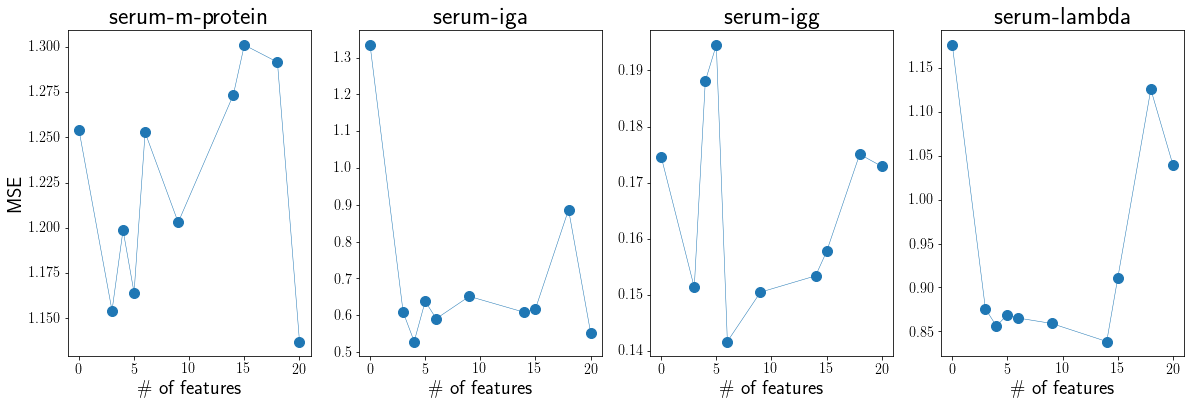

In [11]:
pf_samples 
# x = [0,3,4,5,6,9,12,14,19,20,23,25]
# x_to_model = {
#     0: f'ssm-none-att-fold{fold}',
#     3: f'ssm-car-att-fold{fold}',
#     4: f'ssm-cyc-att-fold{fold}',
#     5: f'ssm-dex-att-fold{fold}',
#     6: f'ssm-len-att-fold{fold}',
#     9: f'ssm-lines-att-fold{fold}',
#     12: f'ssm-demog-att-fold{fold}',
#     14: f'ssm-iss-att-fold{fold}',
#     19: f'ssm-pc-att-fold{fold}',
#     20: f'ssm-hc-att-fold{fold}',
#     23: f'ssm-igg-att-fold{fold}',
#     25: f'ssm-all-att-fold{fold}'
# }
x = [0,3,4,5,6,9,14,15,18,20]
x_to_model = {
    0: f'ssm-none-att-fold{fold}',
    3: f'ssm-car-att-fold{fold}',
    4: f'ssm-cyc-att-fold{fold}',
    5: f'ssm-dex-att-fold{fold}',
    6: f'ssm-len-att-fold{fold}',
    9: f'ssm-lines-att-fold{fold}',
    14: f'ssm-pc-att-fold{fold}',
    15: f'ssm-hc-att-fold{fold}',
    18: f'ssm-igg-att-fold{fold}',
    20: f'ssm-all-att-fold{fold}'
}

X_names = [s.replace('_', '-') for s in X_names_orig]
print(X_names)
fig, axlist = plt.subplots(1,4,figsize=(20,6))
# fig, axlist = plt.subplots(4,4,figsize=(20,30))
ax         = axlist.ravel()
subselect = ['serum-m-protein', 'serum-iga', 'serum-igg', 'serum-lambda']
k = 0
for i,feat in enumerate(X_names): 
    y = []
    if feat not in subselect: 
        continue
    for elem in x: 
        mname  = x_to_model[elem]
        mses   = pf_samples[mname]
        y.append(mses[i])
    ax[k].plot(x,y,ms=10,linewidth=0.5, marker='o')
    ax[k].set_title(feat,fontsize=25)
    ax[k].set_xlabel('$\#$ of features', fontsize=20)
    if k % 4 == 0: 
        ax[k].set_ylabel('MSE',fontsize=20)
#     if k == 0: 
#         ax[k].annotate('+ myeloma type', xy=(23,1.175), xytext=(14,1.19),arrowprops=dict(facecolor='black',arrowstyle='-|>'),fontsize=15) #shrink=0.05
#     if k == 1: 
#         ax[k].annotate('+ treatment', xy=(3.1,0.63), xytext=(3.4,0.7),arrowprops=dict(facecolor='black',arrowstyle='-|>'),fontsize=15) #shrink=0.05
#     if k == 1: 
#         ax[k].annotate('+ all treatments', xy=(6.2,0.63), xytext=(6.1,0.7),arrowprops=dict(facecolor='black',arrowstyle='-|>'),fontsize=15) #shrink=0.05
#         ax[k].annotate('+ genomics', xy=(19,0.9), xytext=(14,1.),arrowprops=dict(facecolor='black',arrowstyle='-|>'),fontsize=15) #shrink=0.05
#         ax[k].annotate('+ myeloma type', xy=(23,0.67), xytext=(16,1.1),arrowprops=dict(facecolor='black',arrowstyle='-|>'),fontsize=15) #shrink=0.05
#     if k == 2: 
#         ax[k].annotate('+ genomics', xy=(19,0.133), xytext=(15,0.14),arrowprops=dict(facecolor='black',arrowstyle='-|>'),fontsize=15) #shrink=0.05
#     ax[k].set_ylim(0.1,1.4)
    k += 1

fig.savefig(f'./plots/mse_ablation_short_reduced.pdf',bbox_inches='tight')


# ax.annotate('local max', xy=(2, 1), xytext=(3, 1.5),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )

In [7]:
X_names_orig = mmdata[fold]['train']['feature_names_x']
A_names = mmdata[fold]['train']['feature_names_a']
B_names = mmdata[fold]['train']['feature_names']
all_names = np.concatenate([X_names_orig, A_names, B_names],0)
print (all_names.shape, X_names_orig.shape)
X_names = [s.replace('_', ' ') for s in X_names_orig]
print(B_names)
print(X_names)
print(A_names)
print(all_names)
print(cond_samples[f'ssm-none-att-fold1'].shape)

(41,) (16,)
Index(['iss', 'age', 'gender', 'ecog', 'serum_beta2_microglobulin', 'PC1',
       'PC2', 'PC3', 'PC4', 'PC5', 'heavy_chain', 'igg_type', 'iga_type',
       'igm_type', 'kappa_type', 'lambda_type'],
      dtype='object')
['cbc abs neut', 'chem albumin', 'chem bun', 'chem calcium', 'chem creatinine', 'chem glucose', 'cbc hemoglobin', 'serum kappa', 'serum m protein', 'cbc platelet', 'chem totprot', 'cbc wbc', 'serum iga', 'serum igg', 'serum igm', 'serum lambda']
['local_clock' 'Bor' 'Car' 'Cyc' 'Dex' 'Len' 'line1' 'line2' 'line3plus']
['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda' 'local_clock' 'Bor' 'Car' 'Cyc' 'Dex' 'Len'
 'line1' 'line2' 'line3plus' 'iss' 'age' 'gender' 'ecog'
 'serum_beta2_microglobulin' 'PC1' 'PC2' 'PC3' 'PC4' 'PC5' 'heavy_chain'
 'igg_type' 'iga_type' 'igm_type' 'kappa_

In [27]:
def plot_features_alt(plotlist, data, treat, X_names, A_names, group = 'serum', nplots = 3, xpush=1,ypush=1):
    assert group in ['serum','cbc'],'bad group'
    if group == 'cbc':
        if nplots == 1:
            fig, axgrid = plt.subplots(nplots,5,figsize=(20,5))
            axgrid = axgrid.reshape(1, 5)
        else:
            fig, axgrid = plt.subplots(nplots,5,figsize=(20,10))
        group_idx   = [3, 4, 6, 9, 7]
    elif group == 'serum':
        if nplots == 1:
#             fig, axgrid = plt.subplots(nplots,5,figsize=(9,5.5))
            fig, axgrid = plt.subplots(nplots,5,figsize=(20,5))
            axgrid = axgrid.reshape(1, 5)
        else:
            fig, axgrid = plt.subplots(nplots,5,figsize=(20,10))
        group_idx   = [12, 13, 14, 15, 7]
#         group_idx   = [13,15]
    else:
        raise ValueError('bad setting for group')
    formatting = {}
    formatting[0] = ('--x','r')
    formatting[1] = ('--o','k')
    formatting[2] = ('--v','g')
    formatting[3] = ('--^','b')
    formatting[4] = ('--.','m')
    
    A_markers  = {}
    A_markers['Bor'] = '>'
    A_markers['Car'] = '<'
    A_markers['Cyc'] = '^'
    A_markers['Len'] = 'v'
    A_markers['Dex'] = 'o'
    axlist = axgrid.ravel()

    from matplotlib.legend import Legend
    lines = []; labels = []
    
    for j, ax in enumerate(axlist): 
        ctr= group_idx[j]
        x  = np.arange(data.shape[1])
        ax.scatter(x, data[0][:,ctr].astype('float'), s=64, label='Data')
        for pltidx, (name, vals) in enumerate(plotlist):
            # x = np.arange(vals.shape[1]) 
            ax.plot(x, vals[0][:,ctr], formatting[pltidx][0], label=name, color=formatting[pltidx][1], alpha = 0.5, markersize=8)
#         if i==0:
        ax.set_title(X_names[ctr], fontsize=25)
        vmin, vmax = scaled_healthy_min_max[X_names_orig[ctr]]
        ax.axhline(y=vmax, color='darkgreen', linestyle='--', alpha=0.6)
        ax.axhline(y=vmin, color='darkgrey', linestyle='--', alpha=0.6)
        ax.xaxis.set_ticks(np.arange(0, data.shape[1], 2))


        ymax = ax.get_ylim()[1]+0.05
        # Plot treatments
#         import pdb; pdb.set_trace()
        treat_i = treat[0]
        for tidx in range(treat_i.shape[1]-1):
            if A_names[tidx]=='local_clock' or 'line' in A_names[tidx]:
                continue
            tlist_x = []
            tlist_y = []
            for t in range(treat_i.shape[0]):
                if treat_i[t, tidx] ==1:
                    tlist_x.append(t)
                    tlist_y.append(ymax+0.34*tidx)
            l = ax.scatter(tlist_x, tlist_y, marker=A_markers[A_names[tidx]])
            if j == 1:
                lines.append(l); labels.append(A_names[tidx])
        
        lot1list_x = []; lot1list_y = []
        lot2list_x = []; lot2list_y = []
        lot3list_x = []; lot3list_y = []
        for t in range(treat_i.shape[0]): 
            line = np.where(treat_i[t][-3:] == 1.)[0]+1
            if line == 1: 
                lot1list_x.append(t); lot1list_y.append(ymax+0.1*treat_i.shape[1]-1)
            elif line == 2: 
                lot2list_x.append(t); lot2list_y.append(ymax+0.1*treat_i.shape[1]-1)
            elif line == 3: 
                lot3list_x.append(t); lot3list_y.append(ymax+0.1*treat_i.shape[1]-1)
#                     ax.fill_between(tlist_x, np.array(tlist_y)+4, np.array(tlist_y)+6, color='darkred', alpha=0.7)
        if j == 1: 
            if len(lot3list_x) != 0: 
                l = ax.fill_between(lot3list_x, np.array(lot3list_y)+.7,np.array(lot3list_y)+1., color='darkgreen', alpha=0.7)
                lines.insert(0,l); labels.insert(0,'Line 3')
            if len(lot2list_x) != 0: 
                l = ax.fill_between(lot2list_x, np.array(lot2list_y)+.7,np.array(lot2list_y)+1., color='darkblue', alpha=0.7)
                lines.insert(0,l); labels.insert(0,'Line 2')
            if len(lot1list_x) != 0: 
                l = ax.fill_between(lot1list_x, np.array(lot1list_y)+.7,np.array(lot1list_y)+1., color='darkred', alpha=0.7)
                lines.insert(0,l); labels.insert(0,'Line 1')

        ylims = ax.get_ylim()
        if j==0:
            ax.legend(loc='best',bbox_to_anchor=(-.3,.3),
                      fancybox=True, shadow=True, ncol=1, fontsize = 25)
        if j==0 or j == 1: 
            ax.set_xlabel('Time (per 2 months)', fontsize=25)
        
    leg = Legend(axlist[0], lines, labels,
                 loc='best', frameon=True, fancybox = True, shadow=True, fontsize=25, bbox_to_anchor=(-.33,1.09))
    axlist[0].add_artist(leg);
    
    plt.subplots_adjust(top=0.9, wspace=0.25)
#     plt.xlabel('Time (per 2 months)', fontsize=25)
    return fig

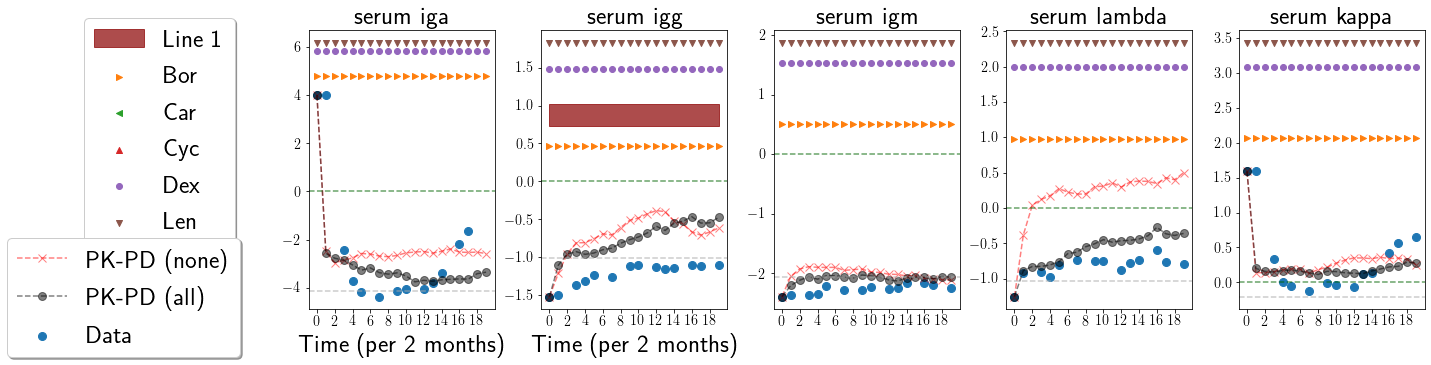

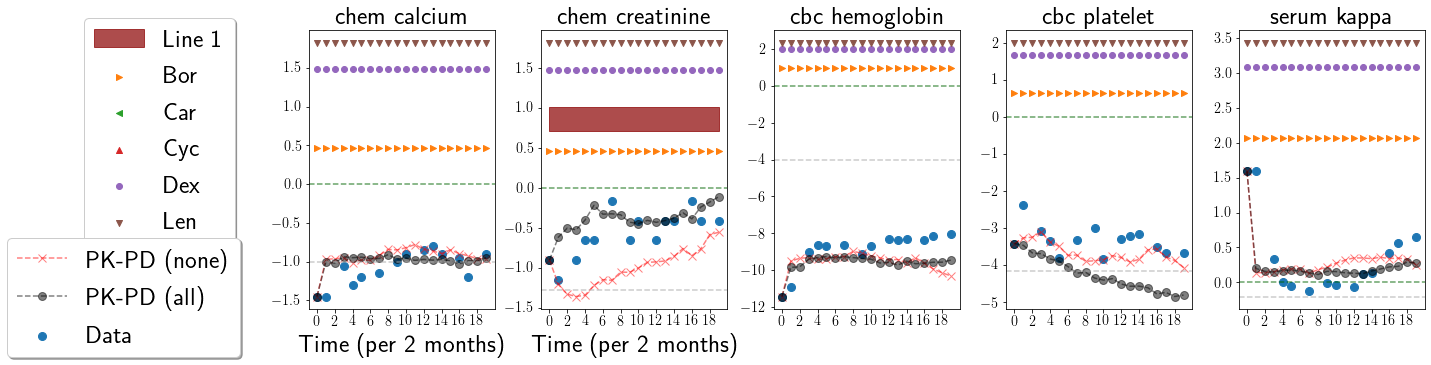

In [40]:
nplots = 1
setup  = 'forward'
idx    = 1
# idxlist = np.arange(prior_samples[f'ssm-att-fold{fold}'].shape[0])+idx

if setup == 'forward':
    l = [('PK-PD (none)', prior_samples[f'ssm-none-att-fold{fold}'][idx:])]
    l += [(f'PK-PD (all)', prior_samples[f'ssm-all-att-fold{fold}'][idx:])]
    fig = plot_features_alt(l, data_prior[idx:], a_prior[idx:], X_names, A_names, group='serum', nplots = nplots, xpush=6.9, ypush=2)
    fig = plot_features_alt(l, data_prior[idx:], a_prior[idx:], X_names, A_names, group='cbc', nplots = nplots, xpush=6.9, ypush=2)
else:
    l = [('PK-PD (none)', cond_samples[f'ssm-none-att-fold{fold}'][idx:])]
    l += [(f'PK-PD (all)', cond_samples[f'ssm-all-att-fold{fold}'][idx:])]
    fig = plot_features_alt(l, data_cond[idx:], a_cond[idx:], X_names, A_names, group='serum', nplots = nplots, xpush=8)
#     fig = plot_features_alt(l, data_cond[idx:], a_cond[idx:], X_names, A_names, group='cbc', nplots = nplots, xpush=8)
# fig.suptitle('Lab for T = %d conditioned on patient %s baseline data'%(T_forward, ','.join([str(k) for k in idxlist[:nplots]])), fontsize=20)
# fig.suptitle('Lab for T = %d conditioned on patient baseline data'%(T_forward), fontsize=20)
# fig.savefig('./plots/fold3_idx5_main_cond10_forw10_2markers.pdf',bbox_inches='tight')